# Helper Functions

In [1]:
# Helper function that will convert your image to gresycale & np.array to use for any tinkering below.
def prepare(filepath):
    IMG_SIZE = 512  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# =======================================================
# THIS ENTIRE NOTEBOOK WILL WORK IF BY JUST CHANGING THE IMAGE & MODEL FILEPATH:

Set your paths, and feel free to click Kernel > Restart & Run All :)

- Download to model: https://drive.google.com/file/d/1-3O2s_QKHeaQC5a7ICLj23IzE6u5YGQt/view?usp=sharing
- Sun-Joo's new image dataset: https://www.dropbox.com/sh/a32rsoqwwy9bxjc/AACIAJzYuhG0vt2pioJDpcAqa?dl=0

In [2]:
# For windows, use \\ to indicate a backslash. On Mac & Linux, use /
model_path = 'G:\\My Drive\\training\\model\\catheter-detect.h5'
img = 'G:\\My Drive\\training\\testcases\\1107-images\\LAO30\\IMG-0004-00364.jpg'

# =======================================================

# Load Model for Predictions

Since we have already trained our model, we can simply call it.

Note to self: Keras has multiple model file outputs:
    - .h5 = Will require you to define the model's architecture. This file only has the weights from training.
    - .hdf5 = Contains the model's architecture, weights, and more.
    
Reference: https://jovianlin.io/saving-loading-keras-models/

This note is really only applicable if you are finetuning the model. For loading, simply call load_model().

In [3]:
import cv2
import tensorflow as tf
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import time

start = time.time()
model = load_model(model_path)
end = time.time()

print('Model Load time (only done once at start): ', end - start)

Using TensorFlow backend.


Model Load time (only done once at start):  3.799436330795288


Model load in time is pretty decent. This only has to be done once.

Let's try to load in an image and see our prediction:

In [4]:
# Calling model.predict() will return an np.array of size (img_index, img_size, img_size, classes).
# For instance, in this example, we want to return the first image and the first class (0, the catheter):
start = time.time()
prediction = model.predict([prepare(img)])
end = time.time()
print('Inference time for a single frame: ', end - start)

predicted_result = prediction[0,:,:,0]


# Each pixel in our prediction array ranged from a confidence level of 0 to 1.0.
# We need to cast it back to uint8 and multiply by 255 to be in greyscale to express our confidence to the human eye.
# This is necessary because findCountours() works with images.
predicted_result = np.uint8(predicted_result * 255)
trace_catheter = cv2.imread(img)
contours, hierarchy = cv2.findContours(predicted_result, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# n is unnecessary here, just used to mask jupyter array output
n = cv2.drawContours(trace_catheter, contours, -1, (0,255,0), 3)

Inference time for a single frame:  4.710286855697632


I believe we have also been informed to try to consider the runtime of this method. It seems like prediction for a single frame is pretty quick for a single frame.

Some things to consider is that this time is not factoring in converting the image/video feed we will be receiving (during demo) into a np.array, converted to greyscale, and then inferred.. we should also time and consider how long calculating the midline is for skeletonization and how long it takes to run and create contours to display onto a screen.

The next code block is just some neat formatting to line up and then output the images below. Irrelevant to the image processing.

(-0.5, 511.5, 511.5, -0.5)

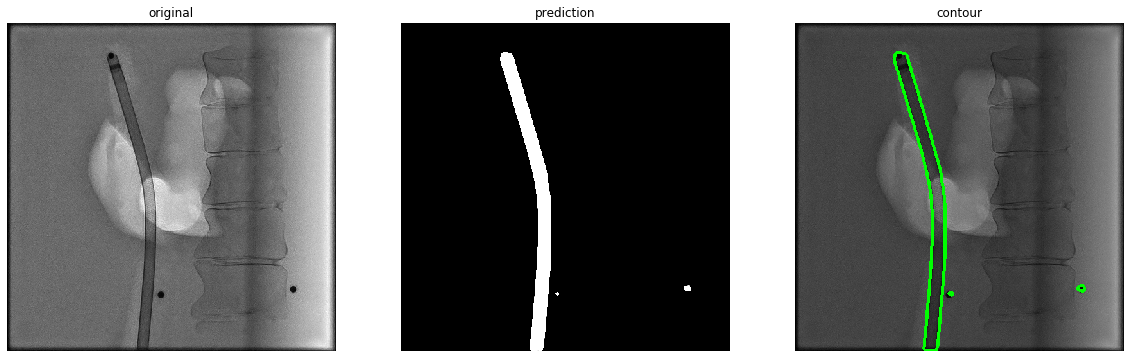

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(prepare(img)[0,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(predicted_result, cmap=plt.cm.gray)
ax[1].set_title('prediction')
ax[1].axis('off')

ax[2].imshow(trace_catheter, cmap=plt.cm.gray)
ax[2].set_title('contour')
ax[2].axis('off')

One thing you might immediately notice is the little dots that also get picked up in the prediction (are these markers? I've never seen these before in past images). These image set is based off of Sun-Joo's new dataset sent over, and it definitely seems like it it performing pretty well given that it hasn't seen any of these images. Perhaps we could get some help in finetuning and introducing this new data to our model.

From the way things are built, everything is pretty modular. Therefore, if the model is retrained and improved, we can simply load in the model here and continue our observations.

Reference to Sun-Joo's dataset used in this notebook:
https://www.dropbox.com/sh/a32rsoqwwy9bxjc/AACIAJzYuhG0vt2pioJDpcAqa?dl=0

# Skeletonization Methodology Analysis

OpenCV doesn't have a built in skeleton function. This is Sun-Joo's skeleton algorithm found online and reimplemented.

This is also the same algorithm used with OpenCV in Sun-Joo's Marker & Catheter Detection Jupyter Notebook.

References:
- https://opencvpython.blogspot.com/2012/05/skeletonization-using-opencv-python.html

In [6]:
def skeleton(img):
    """ OpenCV function to return a skeletonized version of img, a Mat object"""
    #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/
    
    img = img.copy() # don't clobber original
    skel = img.copy()
    
    skel[:,:] = 0
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]
        if cv2.countNonZero(img) == 0:
            break

    return skel

I believe the goal here is to find a nice and smooth midline to be used for measurements and for near future software implementations. Below are some methods to compare some skeletization methods, but the goal is more focused on finding the midline.

### Sun-Joo's Current Method

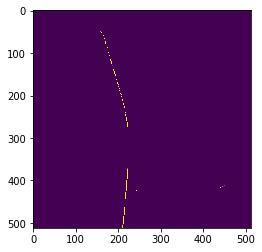

In [7]:
# Sun-Joo's current method
y = skeleton(predicted_result)
plt.imshow(y)

Naturally, the next thing to do is to find if there are any other libraries that might have improved on this algorithm, and also factored in for some of these edge cases/noise that we see here from the gappy lines.

## Using the SciKit Learn Library

We transition over to sklearn to find a more robust algorithm.

It's not listed in this Jupyter Notebook, but during my experimentation, the skeletonization function did have improved results (less breaks and more continuity) compared to OpenCV's method. However, it seems to be working now.

I believe the tresholding used will also help out as well:
https://en.wikipedia.org/wiki/Otsu%27s_method

**This threshold came up in my previous studies, but perhaps this threshold might also be the solution to solving our marker detection's statically defineed thresholds?**

> Otsu's method exhibits the relatively good performance if the histogram can be assumed to have bimodal distribution and assumed to possess a deep and sharp valley between two peaks. But if the object area is small compared with the background area, the histogram no longer exhibits bimodality.

We stated our markers are always pitch black... can we use this to our advantage using Otsu's?

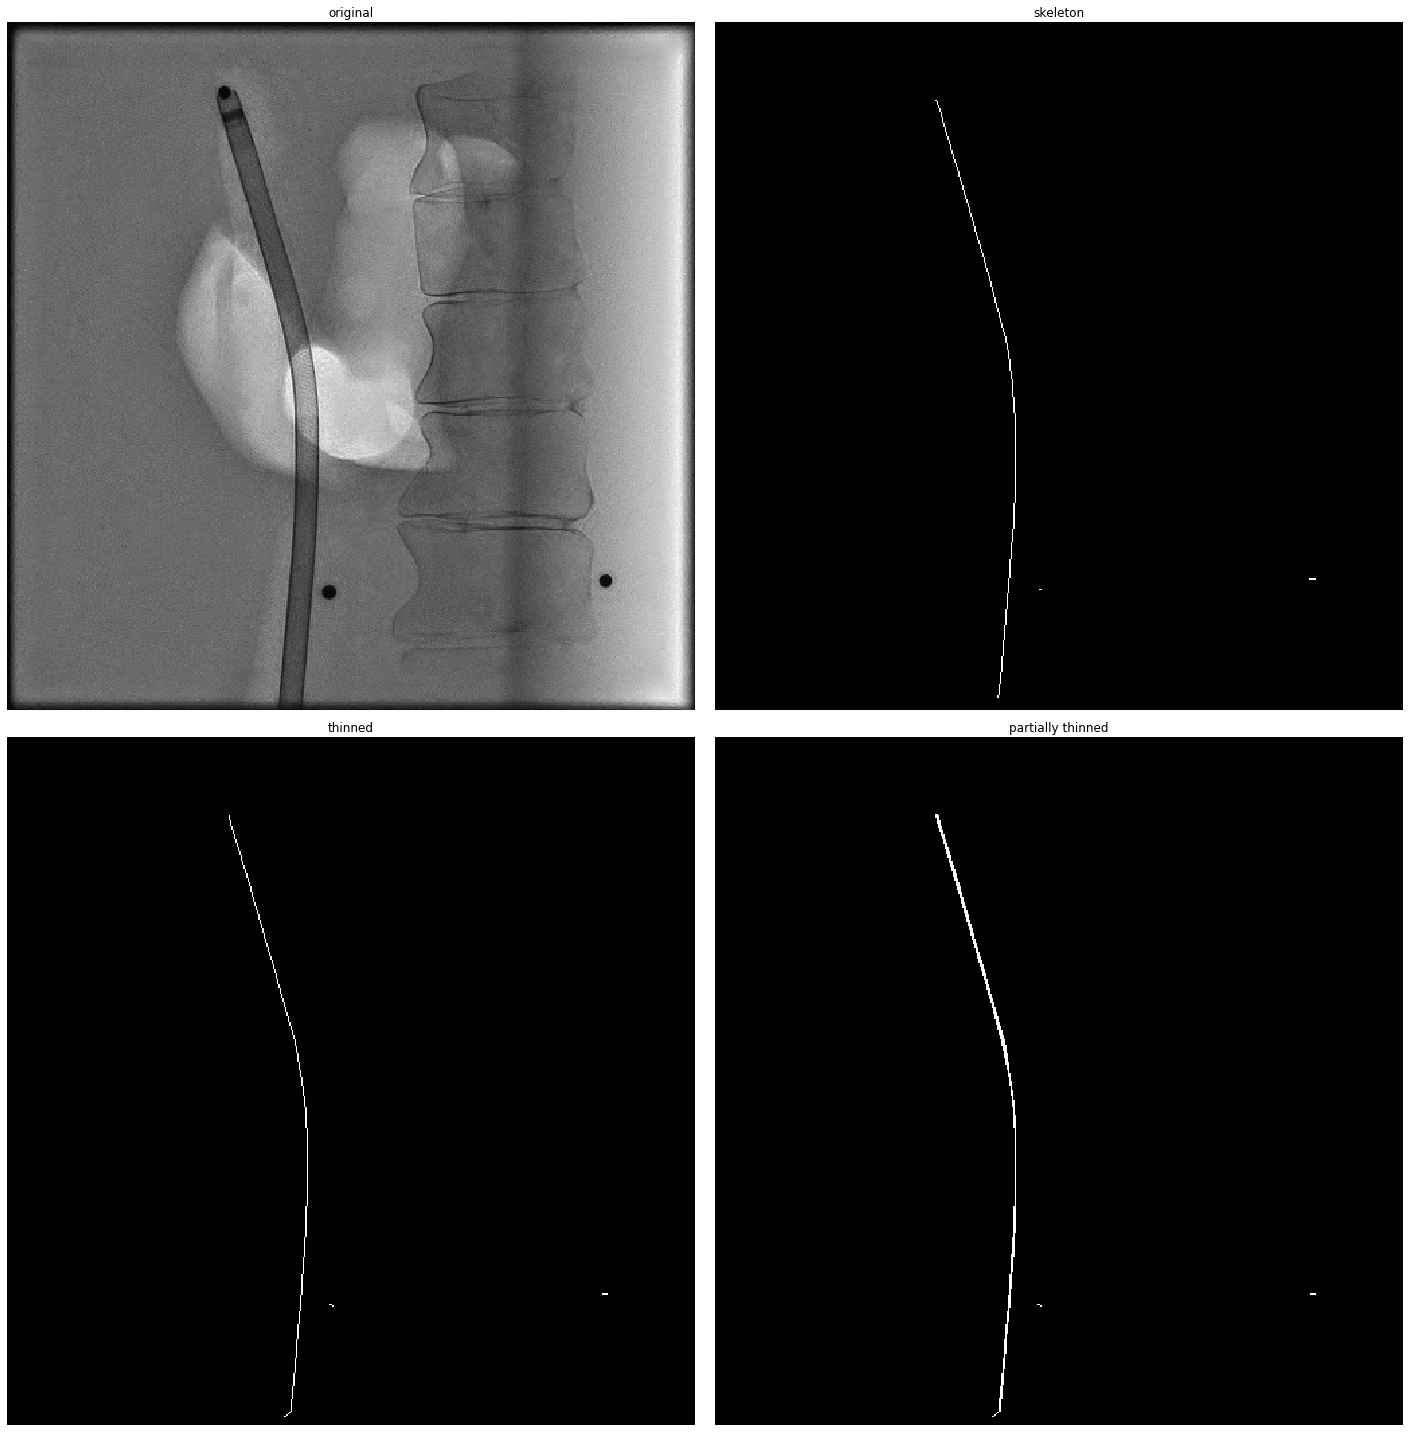

In [8]:
from skimage import filters
from skimage.morphology import skeletonize, thin

# Calling functions to compare
binary = predicted_result > filters.threshold_otsu(predicted_result) # added dynamic thresholding
skeleton = skeletonize(binary)
thinned = thin(predicted_result)
thinned_partial = thin(predicted_result, max_iter=10) # iterations changed to prevent it from over-thinning


# Stuff to make the output look pretty
fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(prepare(img)[0,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeleton')
ax[1].axis('off')

ax[2].imshow(thinned, cmap=plt.cm.gray)
ax[2].set_title('thinned')
ax[2].axis('off')

ax[3].imshow(thinned_partial, cmap=plt.cm.gray)
ax[3].set_title('partially thinned')
ax[3].axis('off')

fig.tight_layout()
plt.show()

### SKLearn Medial Axis

Similar to skeletonization (also from the same reference link as the previous example), medial axis will return points that are midpoint candidates with certain confidence.

I tried tinkering with this and also thought this was a decent method to consider as well. Perhaps this might be useful for vertebrae, but no motivation or thought process behind this yet. Simply brainstorming.

Additional Reference:
https://homepages.inf.ed.ac.uk/rbf/HIPR2/skeleton.htm

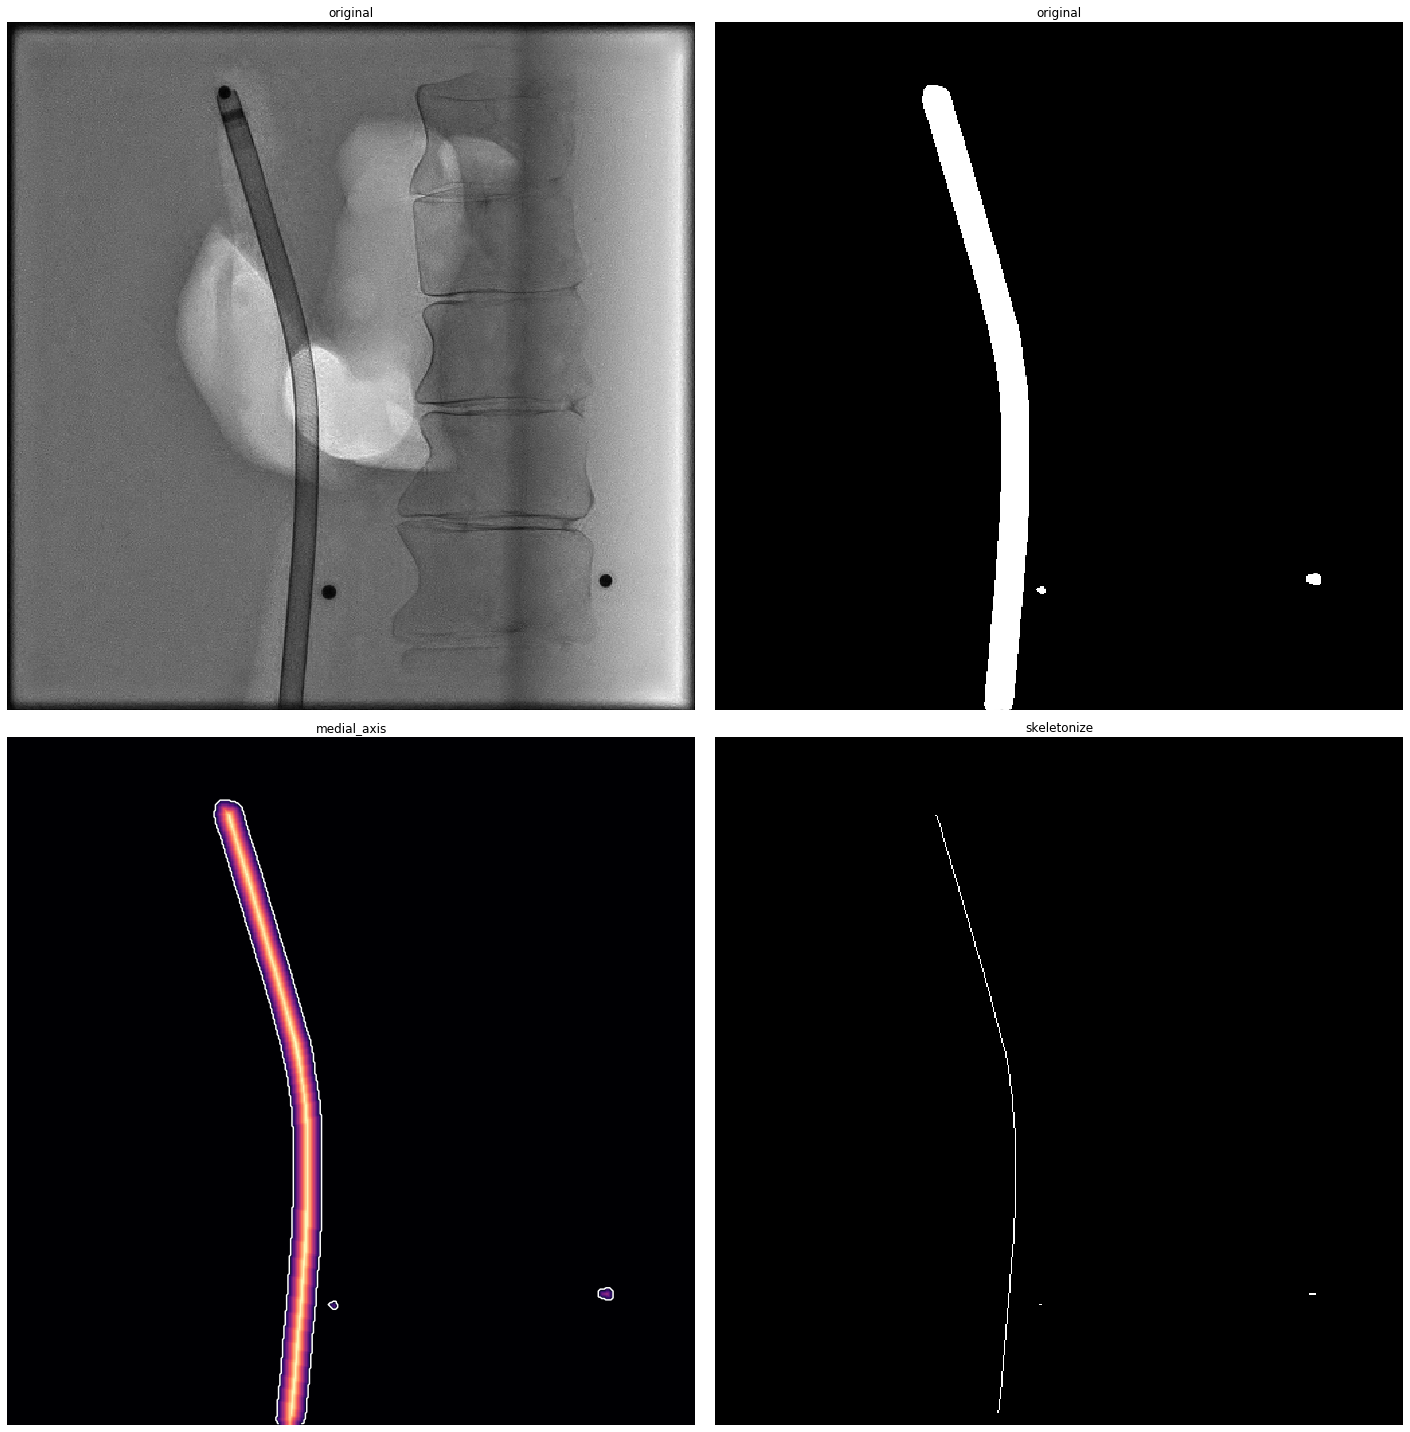

In [9]:
from skimage.morphology import medial_axis, skeletonize

binary = predicted_result > filters.threshold_otsu(predicted_result) # added dynamic thresholding

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(binary, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(binary)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * binary

# Fancy formatting
fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(prepare(img)[0,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(predicted_result, cmap=plt.cm.gray)
ax[1].set_title('original')
ax[1].axis('off')

ax[2].imshow(dist_on_skel, cmap='magma')
ax[2].contour(binary, [0.5], colors='w')
ax[2].set_title('medial_axis')
ax[2].axis('off')

ax[3].imshow(skeleton, cmap=plt.cm.gray)
ax[3].set_title('skeletonize')
ax[3].axis('off')

fig.tight_layout()
plt.show()

Just a thought: Skeletonization works by eroding (thinning away) and dilating (thickening) an object until there is a thickness of 1 pixel left. However, it might seem as if skeletonization is a bit too harsh on skeletonizing the catheter (it looks promising here, so we should try more examples).

If this is the case, there's some potential solutions:
- Use partial thinning from the previous example
- We can rethink the problem as using medial axis, and taking the max of each row to find the max confidence of the midpoint in each row. This could be advantageous because it will ensure continuity given that the object detected is continuous (hypothetically).

Note: it also seems like the little markers in the image have a lower confidence in medial-axis, even though I would prefer to have a better-trained initial model.

(-0.5, 511.5, 511.5, -0.5)

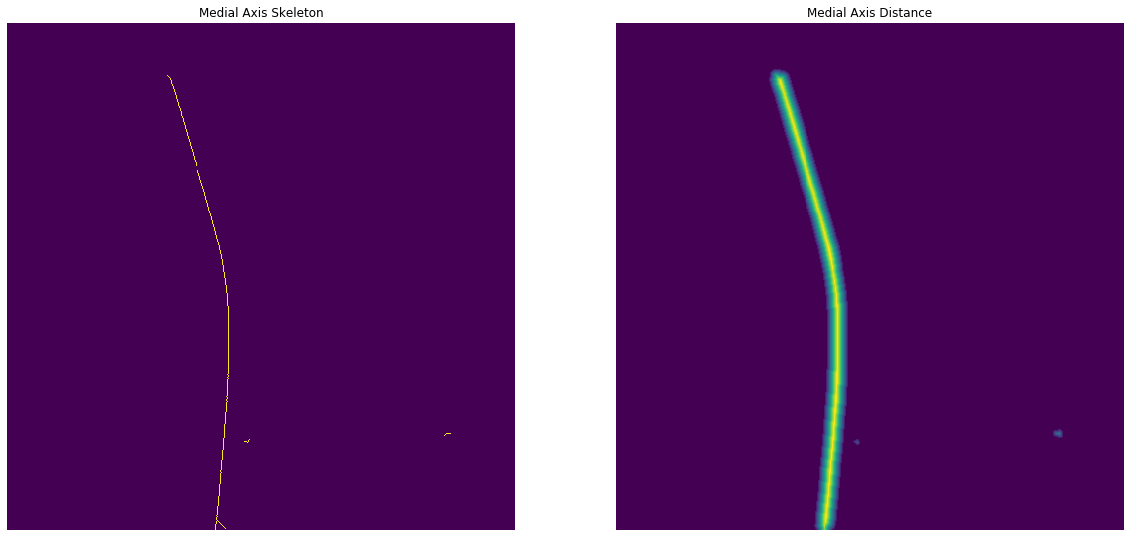

In [10]:
# Fancy formatting
fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(skel)
ax[0].set_title('Medial Axis Skeleton')
ax[0].axis('off')

ax[1].imshow(distance)
ax[1].set_title('Medial Axis Distance')
ax[1].axis('off')


Here's a little plot twist, as im sure this concept is synonymous across many fields and disciplines.. the bias-variance tradeoff in statistics, precision-recall tradeoff in information systems, and precision-accuracy in a general sense.

If we skeletonize, we prioritize precision. If we use medial-axis, we have the option to find our confidences and define a decent threshold for them.

Look at what happens when we decide to do so. In the bottom example, we simple take the distance array (which is one of the arrays returned by medial_axis() and replace all the confidences that are under 9) with a 0, thus eliminating it as a candidate. We then replot.

Note: I still have to explore what a good universal max is. For the image I can used for this experiment, I called max(distance) to determine the max confidence in the np.array/image.

(-0.5, 511.5, 511.5, -0.5)

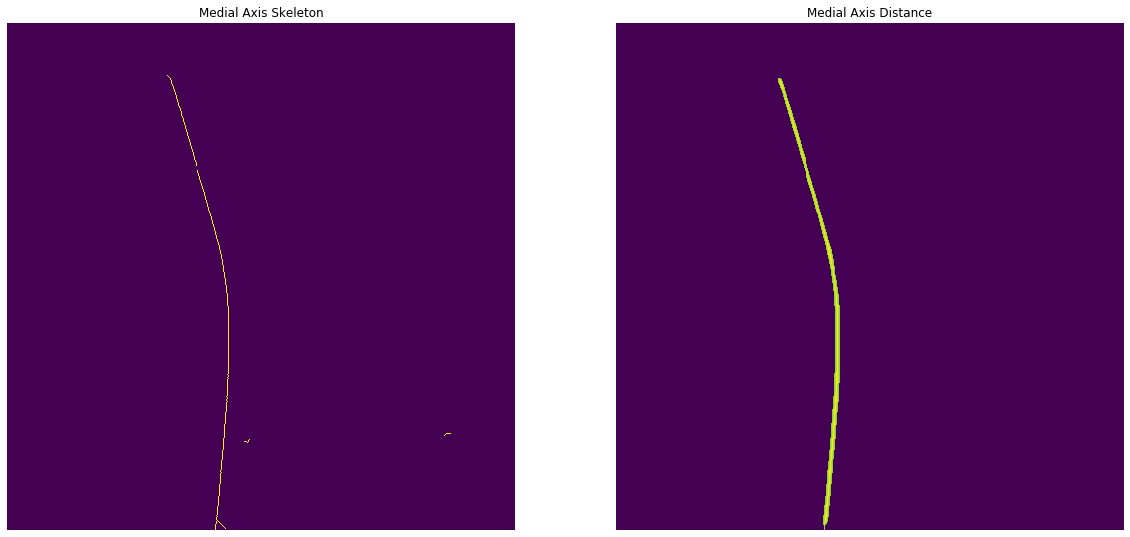

In [11]:
distance_w_threshold = distance
distance_w_threshold[distance_w_threshold < 9] = 0

# Fancy formatting
fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(skel)
ax[0].set_title('Medial Axis Skeleton')
ax[0].axis('off')

ax[1].imshow(distance_w_threshold)
ax[1].set_title('Medial Axis Distance')
ax[1].axis('off')


# We can experiment with more images, but it seems like we have a good set of coordinates for Chantal. However, this might either solve or increase the accuracy of Sun-Joo's method for "connecting the gaps" via interpolation.

# Next up: Implementing prediction of 3D Coordinates